### Assignment 2

#### Submit your assignment as .ipynb

### Zhao Enping

In [1]:
import math
from enum import Enum
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt
import bisect

In [4]:
from binomial import *

#### Exercise 1.

Implement a trinomial tree that takes the below signature:

In [17]:
#def trinomialPricerAnchor(S, r, q, vol, trade, n, K):

Instead of taking the parameter $\lambda$ in our example code, this function takes a discontinuity K and anchors a tree node to K by tuning $\lambda$ inside the pricer.
Note that there are many ways to adjust $\lambda$, one example is to construct the tree with $\lambda = \sqrt{3}$ first, find the node closest to $K$, then adjust $\lambda$ such that the node falls on $K$, but you are free to define your own way to achieve this.

Plot the pricing errors of this trinomial tree pricer with the market and strike below, for number of tree steps from 10 to 300 (similar to our binomial tree test cases).
Use a European Call option and a Binary Call option as test trades.

In [5]:
import numpy as np

In [6]:
a = np.array([1,2,3,4,5])

In [7]:
a[1]

2

In [8]:
K = 105
S, r, vol, q = 100, 0.01, 0.2, 0
n = 300

In [9]:
def lmda_tuner (trade, vol, S, n, K):
    lmda = math.sqrt(3)
    t = trade.expiry / n
    u = math.exp(lmda * vol * math.sqrt(t))
    
    node_list = [S * u ** (n - i) for i in range(2*n + 1)] #get the list of nodes at the last time step
    distance = [abs(node - K) for node in node_list] #calculate the distance between each node and K
    anchor_index = distance.index(min(distance)) # locate the anchor point, which is the node index that is closest to K
    if n == anchor_index:
        anchor_index -=1
    
    lmda = (math.log(K/S))/((n-anchor_index)*vol * math.sqrt(t)) # adjust lmda value
    u = math.exp(lmda * vol * math.sqrt(t))
#    node_list = [S * u ** (n - i) for i in range(2*n + 1)]
#    print (node_list[anchor_index])
    return lmda

In [10]:
def trinomialPricer(S, r, q, vol, trade, n, K):
    lmda = lmda_tuner (trade, vol, S, n, K)
    t = trade.expiry / n
    u = math.exp(lmda * vol * math.sqrt(t))
    mu = r - q
    pu = 1 / 2 / lmda / lmda + (mu - vol * vol / 2) / 2 / lmda / vol * math.sqrt(t)
    pd = 1 / 2 / lmda / lmda - (mu - vol * vol / 2) / 2 / lmda / vol * math.sqrt(t)
    pm = 1 - pu - pd
    # set up the last time slice, there are 2n+1 nodes at the last time slice
    # counting from the top, the i-th node's stock price is S * u^(n - i), i from 0 to n+1

    vs = [trade.payoff(S * u ** (n - i)) for i in range(2*n + 1)]
    
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(2*i + 1):
            nodeS = S * u ** (i - j)
            continuation = math.exp(-r * t) * (vs[j] * pu +  + vs[j+1] * pm + vs[j+2] * pd)
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
#    print(lmda,pu,pm)
    return vs[0]

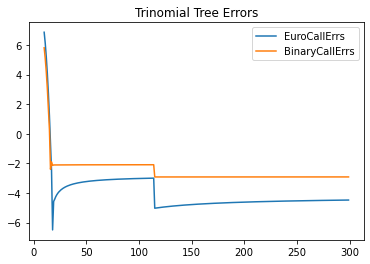

In [11]:
S, r, vol, q, K = 100, 0.01, 0.2, 0, 105
n = 300
opt = EuropeanOption(1, K, PayoffType.Call)
bsprc = bsPrice(S, r, vol, opt.expiry, opt.strike, opt.payoffType)
EuroCallErrs = [math.log(abs(trinomialPricer(S, r, q, vol, opt, i, K) - bsprc)) for i in range(10, n)]

S, r, vol, q, K = 100, 0.01, 0.2, 0, 105
opt = EuropeanOption(1, K, PayoffType.BinaryCall)
bsprc = bsPrice(S, r, vol, opt.expiry, opt.strike, opt.payoffType)
BinaryCallErrs = [math.log(abs(trinomialPricer(S, r, q, vol, opt, i, K) - bsprc)) for i in range(10, n)]

plt.plot(range(10, n), EuroCallErrs, label = "EuroCallErrs")
plt.plot(range(10, n), BinaryCallErrs, label = "BinaryCallErrs")

plt.title("Trinomial Tree Errors")
plt.legend()
plt.show()

#### Exercise 2.

Assuming forward delta convention, implement below function ```strikeFromdelta``` that calculates the strike from a given delta.
You may use the ```fwdDelta``` function below.

In [12]:
from scipy import optimize

class PayoffType(Enum):
    Call = 0
    Put = 1
def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def fwdDelta(fwd, stdev, strike, payoffType):
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    if payoffType == PayoffType.Call:
        return cnorm(d1)
    elif payoffType == PayoffType.Put:
        return -cnorm(-d1)
    else:
        raise Exception("not supported payoff type", payoffType)

# solve for the K such that Delta(S, T, K, vol) = delta, assuming forward delta convention
def strikeFromDelta(T, S, r, q, vol, delta, payoffType):
    strike = 0
    
    fwd = S * math.exp((r-q) * T)
    stdev = vol * math.sqrt(T)
    
    lower_bound = 0.0000001
    upper_bound = S*10 # just to make this number large, so that the strike is impossible to exceed upper bound
    
    implied_strike = optimize.brentq(lambda x: delta - fwdDelta(fwd, stdev, x, payoffType), lower_bound, upper_bound)

    return implied_strike

In [13]:
strikeFromDelta(1, 100, 0.02, 0.0, 0.2, 0.5, PayoffType.Call)

104.08107741923882

#### Exercise 3.

Implement ```smilefromMarks``` function below, it take the time to maturity $T$, current stop price $S$, risk free and dividend rate $r$ and $q$,
ATM volatility, BF25, RR25, BF10, RR10 quotes, returns a CubicSpline interpolated smile for this pillar. We assume ATM forward convention. 
You may use the Smile class provided below.   

In [14]:
class Smile:
    def __init__(self, strikes, vols):
        # add additional point on the right to avoid arbitrage
        self.strikes = strikes  + [1.1*strikes[-1] - 0.1*strikes[-2]]
        self.vols = vols + [vols[-1] + (vols[-1]-vols[-2])/10]
        self.cs = CubicSpline(strikes, vols, bc_type=((1, 0.0), (1, 0.0)), extrapolate=True)
    def Vol(self, k):
        if k < self.strikes[0]:  # scipy cubicspline bc_type confusing, extrapolate by ourselfs
            return self.vols[0]
        if k > self.strikes[-1]:
            return self.vols[-1]
        else:
            return self.cs(k)

def smileFromMarks(T, S, r, q, atmvol, bf25, rr25, bf10, rr10):

    vol_10_call = bf10 + atmvol + 0.5*rr10
    vol_10_put  = bf10 + atmvol - 0.5*rr10
    vol_25_call = bf25 + atmvol + 0.5*rr25
    vol_25_put  = bf25 + atmvol - 0.5*rr25        
    
    atm_strike    = S * math.exp((r-q)*T)

    trike_put_10  = strikeFromDelta(T, S, r, q, vol_10_put, -0.1, PayoffType.Put)
    trike_call_10 = strikeFromDelta(T, S, r, q, vol_10_call, 0.1, PayoffType.Call)
    trike_put_25  = strikeFromDelta(T, S, r, q, vol_25_put, -0.25, PayoffType.Put)
    trike_call_25 = strikeFromDelta(T, S, r, q, vol_25_call, 0.25, PayoffType.Call)
             
    strikes = [trike_put_10, trike_put_25, atm_strike, trike_call_25, trike_call_10]
    vols = [vol_10_put, vol_25_put, atmvol, vol_25_call, vol_10_call]

    return Smile(strikes, vols)

With ```smileFromMarks```, we can prepare our implied volatility surface from input marks.

In [15]:
class ImpliedVol:
    def __init__(self, ts, smiles):
        self.ts = ts
        self.smiles = smiles
    # linear interpolation in variance, along the strike line
    def Vol(self, t, k):
        # locate the interval t is in
        pos = bisect.bisect_left(self.ts, t)
        # if t is on or in front of first pillar,
        if pos == 0:
            return self.smiles[0].Vol(k)
        if pos >= len(self.ts):
            return self.smiles[-1].Vol(k)
        else:  # in between two brackets
            prevVol, prevT = self.smiles[pos-1].Vol(k), self.ts[pos-1]
            nextVol, nextT = self.smiles[pos].Vol(k), self.ts[pos]
            w = (nextT - t) / (nextT - prevT)
            prevVar = prevVol * prevVol * prevT
            nextVar = nextVol * nextVol * nextT
            return  math.sqrt((w * prevVar + (1-w) * nextVar)/t)
        return
    def dVoldK(self, t, k):
        return (self.Vol(t, k+0.01) - self.Vol(t, k-0.01)) / 0.02
    def dVoldT(self, t, k):
        return (self.Vol(t+0.005, k) - self.Vol(t, k)) / 0.005
    def dVol2dK2(self, t, k):
        return (self.Vol(t, k+0.01) + self.Vol(t, k-0.01) - 2*self.Vol(t, k)) / 0.0001

Plot the test implied volatility surface using below test functions.

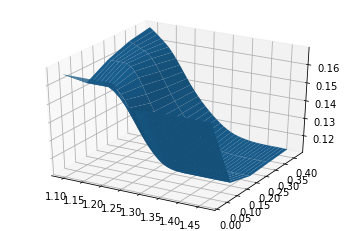

In [16]:
def createTestImpliedVol(S, r, q):
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5] # in year
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
    bf25s = [0.0016, 0.0016, 0.0021, 0.0028, 0.0034, 0.0043, 0.0055, 0.0058, 0.0060, 0.0055, 0.0054, 0.0050, 0.0045, 0.0043]
    rr25s = [-0.0065, -0.0110, -0.0143, -0.0180, -0.0238, -0.0288, -0.0331, -0.0344, -0.0349, -0.0340, -0.0335, -0.0330, -0.0330]
    bf10s = [0.0050, 0.0050, 0.0067, 0.0088, 0.0111, 0.0144, 0.0190, 0.0201, 0.0204, 0.0190, 0.0186, 0.0172, 0.0155, 0.0148]
    rr10s = [-0.0111, -0.0187, -0.0248, -0.0315, -0.0439, -0.0518, -0.0627, -0.0652, -0.0662, -0.0646, -0.0636, -0.0627, -0.0627]
    smiles = [smileFromMarks(pillars[i], S, r, q, atmvols[i], bf25s[i], rr25s[i], bf10s[i], rr10s[i]) for i in range(len(pillars))]
    return ImpliedVol(pillars, smiles)

def plotTestImpliedVolSurface():
    S, r, q = 1.25805, 0.01, 0.003
    iv = createTestImpliedVol(S, r, q)
    tStart, tEnd = 0.02, 0.5
    ts = np.arange(tStart, tEnd, 0.1)
    fwdEnd = S*math.exp((r-q)*tEnd)
    kmin = strikeFromDelta(tEnd, S, r, q , iv.Vol(tEnd, fwdEnd), -0.05, PayoffType.Put)
    kmax = strikeFromDelta(tEnd, S, r, q , iv.Vol(tEnd, fwdEnd), 0.05, PayoffType.Call)
    ks = np.arange(kmin, kmax, 0.01)

    vs = np.ndarray((len(ts), len(ks)))
    for i in range(len(ts)):
        for j in range(len(ks)):
            vs[i, j] = iv.Vol(ts[i], ks[j])
    hf = plt.figure()
    ha = hf.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(ks, ts)
    ha.plot_surface(X, Y, vs)
    plt.show()
    
plotTestImpliedVolSurface()